In [160]:
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt



In [161]:
def generate_data(n_components=5, n_samples=100):
    # Generate means
    means = torch.rand(n_components, 2)
    # Generate variances
    variances = 0.03 * torch.ones((n_components,))
    # Generate X
    X = []
    Z = []
    for z in xrange(n_components):
        x = means[z] + variances[z] * torch.randn(n_samples, 2)
        X.append(x)
        Z.append(z*torch.ones(n_samples).long())
    X = torch.cat(X, 0)
    Z = torch.cat(Z, 0)
    return X, Z

def plot_samples(X, Z=None):
    plt.axis('equal')
    if Z is not None:
        z_max = Z.max()
        for z in xrange(z_max+1):
            X_z = X[Z==z]
            plt.scatter(X_z.numpy()[:,0], X_z.numpy()[:,1], label=z)
        plt.legend()
    else:
        plt.scatter(X.numpy()[:,0], X.numpy()[:,1])

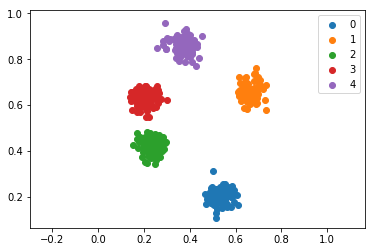

In [185]:
torch.manual_seed(7)
X, Z = generate_data()

plot_samples(X, Z)

# K-means

In [186]:
def get_pairwise_distances(m, n):
    assert m.size()[1] == n.size()[1]
    assert len(m.size()) == 2 and len(n.size()) == 2
    distance_matrix = ((m[:, :, None] - n.t()[None, :, :])**2).sum(1)
    return distance_matrix

# Example
m = torch.tensor([
    [1, 2],
    [3, 4],
    [5, 6]])

n = torch.tensor([
    [1, 2],
    [3, 4]])

get_pairwise_distances(m, n)

tensor([[  0,   8],
        [  8,   0],
        [ 32,   8]])

In [189]:
# Initialize
n_components = 5
#centroids = torch.rand(n_components, 2)
# initialize to 5 first points
centroids = X[:5].clone()
iterations = 15
for iteration in xrange(iterations):
    # Expectation
    distances = get_pairwise_distances(X, centroids)
    __, assignments = torch.min(distances, 1)
    # Minimization
    for i in xrange(n_components):
        centroids[i] = X[assignments == i].mean(0)

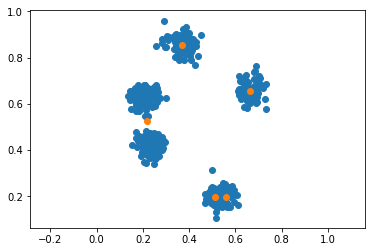

In [190]:
# Plot centroids
plt.figure()
plot_samples(X)
plot_samples(centroids)

# Wasserstein Clustering

In [248]:
def compute_sinkhorn(m, r=None, c=None, regularization=100., iterations=40):
    '''
    pairwise_distances: (batch, batch')
    r: (batch, dims) distribution (histogram)
    c: (batch', dims) distribution (histogram)
    '''
    # If no distributions are given, consider two uniform histograms
    if r is None:
        r = torch.ones(m.size()[0]) / m.size()[0]
    if c is None:
        c = torch.ones(m.size()[1]) / m.size()[1]
    
    # Initialize dual variable v (u is implicitly defined in the loop)
    v = torch.ones(m.size()[1])
    
    # Exponentiate the pairwise distance matrix
    K = torch.exp(-regularization * m)
    
    # Main loop
    for i in xrange(iterations):
        # Kdiag(v)_ij = sum_k K_ik diag(v)_kj = K_ij v_j
        # Pij = u_i K_ij v_j
        # sum_j Pij = u_i sum_j K_ij v_j = u_i (Kv)_i = r_i
        # -> u_i = r_i / (Kv)_i
        # K * v[None, :]
        
        # Match r marginals
        u = r / torch.matmul(K, v)

        # Match c marginals
        v = c / torch.matmul(u, K)
  
        #print 'P', P
        #print '~r', P.sum(1)
        #print '~c', P.sum(0)
        #print 'u', u
        #print 'v', v        
    # Compute optimal plan, cost, return everything
    P = u[:, None] * K * v[None, :]  # transport plan
    dst = (P * m).sum()
    
    return dst, P, u, v

m = torch.tensor([[0,1],[1,0]]).float()
dst, P, u, v = compute_sinkhorn(m, regularization=100.)
print dst

tensor(1.00000e-44 *
       3.9236)


In [337]:
# Initialize
n_components = 5
# initialize to 5 first points
centroids = X[:5].clone()
#centroids = torch.zeros_like(X[:5])  # will get stuck
iterations = 8
for iteration in xrange(iterations):
    # Expectation - Compute Sinkhorn distance
    distances = get_pairwise_distances(X, centroids)
    dst, P, u, v = compute_sinkhorn(distances, regularization=100.)
    print centroids
    # P_ij / sum_i P_ij is soft-assignment of cluster j
    assignments = P / P.sum(0, keepdim=True)

    # Minimization
    centroids = torch.matmul(assignments.t(), X)

tensor([[ 0.5928,  0.2284],
        [ 0.5532,  0.1814],
        [ 0.5364,  0.1892],
        [ 0.4874,  0.1891],
        [ 0.5238,  0.2226]])
tensor([[ 0.5948,  0.6909],
        [ 0.4777,  0.3454],
        [ 0.3756,  0.4636],
        [ 0.2334,  0.5298],
        [ 0.3214,  0.7330]])
tensor([[ 0.6565,  0.6621],
        [ 0.5337,  0.1987],
        [ 0.2415,  0.4504],
        [ 0.2032,  0.5912],
        [ 0.3617,  0.8492]])
tensor([[ 0.6627,  0.6573],
        [ 0.5338,  0.1989],
        [ 0.2319,  0.4322],
        [ 0.2062,  0.6182],
        [ 0.3679,  0.8553]])
tensor([[ 0.6627,  0.6573],
        [ 0.5338,  0.1989],
        [ 0.2322,  0.4271],
        [ 0.2060,  0.6237],
        [ 0.3681,  0.8556]])
tensor([[ 0.6627,  0.6573],
        [ 0.5338,  0.1989],
        [ 0.2323,  0.4263],
        [ 0.2059,  0.6246],
        [ 0.3681,  0.8556]])
tensor([[ 0.6627,  0.6573],
        [ 0.5338,  0.1989],
        [ 0.2323,  0.4262],
        [ 0.2059,  0.6247],
        [ 0.3681,  0.8556]])
tensor([[ 0.6

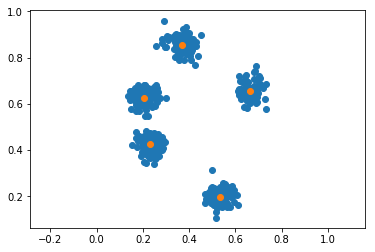

In [338]:
# Plot centroids
plt.figure()
plot_samples(X)
plot_samples(centroids)